In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# 1. Load dữ liệu
data = pd.read_csv("features_mediapipe_merged_cleaned_xyz.csv")
X = data.drop(columns=["label", "handedness"])
y = data["label"]
manual_map = {
    -20: 26,  # del
    30: 27,   # space
    # thêm nếu có
}
y = y.map(manual_map).fillna(y).astype(int)

import pickle
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.99) 
pca.fit(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_test = y_test.to_numpy() if hasattr(y_test, "to_numpy") else y_test

print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [2]:
# In thứ tự của cột X
print(X.columns.tolist())

['landmark_0_x', 'landmark_1_x', 'landmark_2_x', 'landmark_3_x', 'landmark_4_x', 'landmark_5_x', 'landmark_6_x', 'landmark_7_x', 'landmark_8_x', 'landmark_9_x', 'landmark_10_x', 'landmark_11_x', 'landmark_12_x', 'landmark_13_x', 'landmark_14_x', 'landmark_15_x', 'landmark_16_x', 'landmark_17_x', 'landmark_18_x', 'landmark_19_x', 'landmark_20_x', 'landmark_0_y', 'landmark_1_y', 'landmark_2_y', 'landmark_3_y', 'landmark_4_y', 'landmark_5_y', 'landmark_6_y', 'landmark_7_y', 'landmark_8_y', 'landmark_9_y', 'landmark_10_y', 'landmark_11_y', 'landmark_12_y', 'landmark_13_y', 'landmark_14_y', 'landmark_15_y', 'landmark_16_y', 'landmark_17_y', 'landmark_18_y', 'landmark_19_y', 'landmark_20_y', 'landmark_0_z', 'landmark_1_z', 'landmark_2_z', 'landmark_3_z', 'landmark_4_z', 'landmark_5_z', 'landmark_6_z', 'landmark_7_z', 'landmark_8_z', 'landmark_9_z', 'landmark_10_z', 'landmark_11_z', 'landmark_12_z', 'landmark_13_z', 'landmark_14_z', 'landmark_15_z', 'landmark_16_z', 'landmark_17_z', 'landmark

In [3]:
from sklearn.utils.class_weight import compute_class_weight

print(np.isnan(X_train).sum(), np.isinf(X_train).sum())
print("y_train unique values:", np.unique(y_train))
print("X_train min:", X_train.min(), "max:", X_train.max())
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

landmark_0_x     0
landmark_1_x     0
landmark_2_x     0
landmark_3_x     0
landmark_4_x     0
                ..
landmark_16_z    0
landmark_17_z    0
landmark_18_z    0
landmark_19_z    0
landmark_20_z    0
Length: 63, dtype: int64 landmark_0_x     0
landmark_1_x     0
landmark_2_x     0
landmark_3_x     0
landmark_4_x     0
                ..
landmark_16_z    0
landmark_17_z    0
landmark_18_z    0
landmark_19_z    0
landmark_20_z    0
Length: 63, dtype: int64
y_train unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
X_train min: landmark_0_x     0.002371
landmark_1_x     0.076820
landmark_2_x     0.072004
landmark_3_x     0.052851
landmark_4_x    -0.001383
                   ...   
landmark_16_z   -0.798544
landmark_17_z   -0.580958
landmark_18_z   -0.676480
landmark_19_z   -0.674067
landmark_20_z   -0.719341
Length: 63, dtype: float64 max: landmark_0_x     1.082140
landmark_1_x     1.053736
landmark_2_x     1.018716
landmark_3_x 

In [4]:
import pickle
from sklearn.decomposition import PCA

import tensorflow as tf
class PCALayer(tf.keras.layers.Layer):
    def __init__(self, mean, scale, components):
        super(PCALayer, self).__init__()
        self.mean = tf.constant(mean, dtype=tf.float32)
        self.scale = tf.constant(scale, dtype=tf.float32)
        self.components = tf.constant(components, dtype=tf.float32)

    def call(self, inputs):
        # Standardize
        x = (inputs - self.mean) / self.scale
        # Project
        return tf.linalg.matmul(x, self.components, transpose_b=True)

mean = scaler.mean_
scale = scaler.scale_
components = pca.components_

In [5]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int64')
    
    tp = K.sum(K.cast(K.equal(y_true, y_pred_labels), 'float32'))
    precision = tp / (K.sum(K.cast(K.not_equal(y_pred_labels, 0), 'float32')) + K.epsilon())
    recall = tp / (K.sum(K.cast(K.not_equal(y_true, 0), 'float32')) + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    model.add(PCALayer(mean, scale, components))

    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=64, max_value=640, step=64),
            activation="relu"
        ))
        model.add(layers.Dropout(hp.Float("dropout_rate", 0.15, 0.45, step=0.1)))

    model.add(layers.Dense(len(np.unique(y_train)), activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 5e-5, 1e-3, sampling="log")
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_score]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_f1_score",  # sử dụng F1 Score trên tập validation làm tiêu chí tối ưu
    max_trials=100,
    executions_per_trial=1,
    directory="keras_tuner_dir",
    project_name="asl_landmark_tuning"
)

tuner.search(X_train, y_train,
             validation_data=(X_test, y_test),
             epochs=12,
             batch_size=128,
             class_weight=class_weights_dict,
             callbacks=[
                 keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
             ])

Trial 100 Complete [00h 00m 14s]
val_f1_score: 0.9842251539230347

Best val_f1_score So Far: 0.12298986315727234
Total elapsed time: 00h 25m 02s


In [6]:
best_model = tuner.get_best_models(1)[0]

best_model.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=12, batch_size=32)

best_model.export("asl_best_model_tf")

Epoch 1/12


c:\Users\Loli\.pyenv\pyenv-win\versions\3.12.9\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2466/2466 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2411 - f1_score: 0.2471 - loss: 2.7454 - val_accuracy: 0.6365 - val_f1_score: 0.6619 - val_loss: 1.6397
Epoch 2/12
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step - accuracy: 0.5952 - f1_score: 0.6173 - loss: 1.5801 - val_accuracy: 0.8103 - val_f1_score: 0.8428 - val_loss: 0.9642
Epoch 3/12
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - accuracy: 0.7406 - f1_score: 0.7711 - loss: 1.0108 - val_accuracy: 0.8821 - val_f1_score: 0.9163 - val_loss: 0.6314
Epoch 4/12
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 2s 983us/step - accuracy: 0.8169 - f1_score: 0.8484 - loss: 0.7151 - val_accuracy: 0.9164 - val_f1_score: 0.9520 - val_loss: 0.4596
Epoch 5/12
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step - accuracy: 0.8596 - f1_score: 0.8933 - loss: 0.5555 - val_accuracy: 0.9352 - val_f1_score: 0.9707 - val_loss: 0.3637
Epoch 6/12
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - accuracy: 0.8874 - f1_score: 0.9218 - loss: 0.4578 - val_accuracy: 0.9432 - val_f1_sc

INFO:tensorflow:Assets written to: asl_best_model_tf\assets


Saved artifact at 'asl_best_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 63), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  2280912038480: TensorSpec(shape=(63,), dtype=tf.float32, name=None)
  2280912036944: TensorSpec(shape=(63,), dtype=tf.float32, name=None)
  2280912035216: TensorSpec(shape=(18, 63), dtype=tf.float32, name=None)
  2280912033104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2280912039440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2280918497616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2280918495120: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [7]:
# mandatory test: X_mandatory_test has 2 columns, the first is the feature vector and the second is the label

X_mandatory_test = np.array([
    [0.4796351, 0.51221037, 0.5189155, 0.46231276, 0.39583457, 0.5308335, 0.5636285, 0.5743956, 0.5831104, 0.47416335, 0.47482842, 0.46981606, 0.4721089, 0.42647865, 0.39960808, 0.39015543, 0.39242357, 0.39671496, 0.37963417, 0.39341065, 0.41074744, 1.0245972, 1.0052624, 0.9325657, 0.86417174, 0.82210505, 0.79905677, 0.6890111, 0.6259612, 0.569752, 0.7876404, 0.6689524, 0.5974513, 0.54101664, 0.8036376, 0.70929724, 0.642066, 0.5765569, 0.8450139, 0.83268374, 0.8830221, 0.93489176],
    [0.46506932, 0.5673108, 0.6146883, 0.5988295, 0.52522403, 0.5670886, 0.58538723, 0.5949424, 0.5940366, 0.5052191, 0.5421544, 0.59467155, 0.62957895, 0.43425384, 0.4988721, 0.5324819, 0.5295688, 0.3711862, 0.46229196, 0.50085974, 0.50035214, 0.96138644, 0.90181184, 0.73435205, 0.5952459, 0.5143259, 0.62394226, 0.46498606, 0.36383924, 0.27791882, 0.61102164, 0.43478802, 0.34119374, 0.25939864, 0.6207669, 0.50806534, 0.6175792, 0.7009959, 0.6424121, 0.5863017, 0.66742945, 0.7325335]
    ])

Y_mandatory_true = np.array([
    'W', 
    'R'
    ])

# X_mandatory_test = PCA.transform(X_mandatory_test)

# test the model with the mandatory test data
Y_mandatory_pred = best_model.predict(X_mandatory_test)
Y_mandatory_pred_labels = np.argmax(Y_mandatory_pred, axis=1)

# Change all to characters
Y_mandatory_pred_labels = [chr(label + 65) for label in Y_mandatory_pred_labels]

for i in range(len(X_mandatory_test)):
    if Y_mandatory_pred_labels[i] != Y_mandatory_true[i]:
        print(f"Test failed for input {i}: expected {Y_mandatory_true[i]}, got {Y_mandatory_pred_labels[i]}")
    else:
        print(f"Test passed for input {i}: expected {Y_mandatory_true[i]}, got {Y_mandatory_pred_labels[i]}")



ValueError: Exception encountered when calling PCALayer.call().

[1mDimensions must be equal, but are 42 and 63 for '{{node sequential_1/pca_layer_1/sub}} = Sub[T=DT_FLOAT](data, sequential_1/pca_layer_1/sub/y)' with input shapes: [2,42], [63].[0m

Arguments received by PCALayer.call():
  • inputs=tf.Tensor(shape=(2, 42), dtype=float32)

In [8]:
converter = tf.lite.TFLiteConverter.from_saved_model("asl_best_model_tf")
tflite_model = converter.convert()

with open("asl_landmark_model_local_xyz.tflite", "wb") as f:
    f.write(tflite_model)

617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


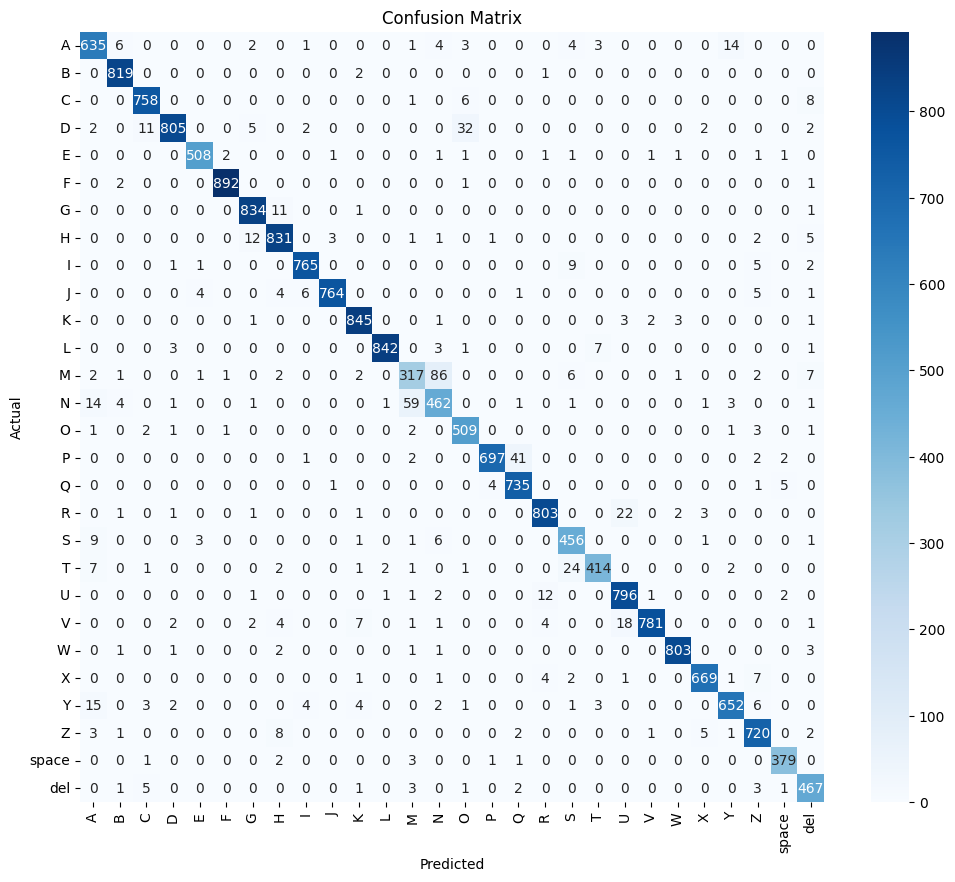

Overall Accuracy: 0.9611


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = y_test
y_pred = best_model.predict(X_test) 
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_labels)

label_names = [chr(ord('A') + i) for i in range(26)] + ['del', 'space', 'nothing']  # nếu dùng 29 lớp

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names[:cm.shape[0]],
            yticklabels=label_names[:cm.shape[0]])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred_labels, labels=np.unique(y_true))

report_df = pd.DataFrame({
    'Label': label_names[:len(precision)],
    'Precision': np.round(precision, 3),
    'Recall': np.round(recall, 3),
    'F1-score': np.round(f1, 3),
    'Support': support
})

overall_accuracy = np.mean(y_true == y_pred_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")